Import Libraries

In [3]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
from collections import Counter
import torch.utils.data as data
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
%matplotlib inline
from torchsummary import summary
import torch.nn as nn
import torchvision.models as models



Set up device, Use GPU if available else use CPU

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Mount Drive to access data from it and to write to it

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extract Train and Validation Data to the active directory

In [ ]:
!tar -xvf '/content/drive/MyDrive/test_set.tar'

Function to prepare dataset for use

In [4]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define a dictionary to convert expressions to integers
expressions_dict = {'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}

# Define a dictionary to map suffixes to variable names
suffixes_dict = {'_exp.npy': 'expression', '_aro.npy': 'arousal', '_val.npy': 'valence'}

class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.annotation_dir = os.path.join(root_dir, 'annotations')
        self.image_suffix = '.jpg'
        
        self.image_names = os.listdir(self.image_dir)
        self.annotation_names = [name.replace(self.image_suffix, '') for name in self.image_names]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        annotation_name = self.annotation_names[idx]
        
        # Load the image
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)
        
        # Load the annotations
        annotation = {}
        for suffix, var_name in suffixes_dict.items():
            path = os.path.join(self.annotation_dir, annotation_name + suffix)
            if os.path.exists(path):
                annotation[var_name] = np.load(path, allow_pickle=True).item()
        
        if not annotation:
            print(f"No annotations found for {image_name}")
            return None
        
        # Check if expression label is valid
        expression_label = annotation.get('expression')
        # if expression_label is None or int(expression_label) not in expressions_dict:
        #     print(expression_label,': ',f"Unknown or missing expression label for {image_name}\n")
            
        #     return None
        
        # Get the values of the annotations
        expression = expression_label
        expression = int(expression)
        arousal = float(annotation.get('arousal'))
        valence = float(annotation.get('valence'))


        
        # Apply transform if provided
        if self.transform:
            image = self.transform(image)
        
        # Convert the annotations to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float)
        expression = torch.tensor(expression, dtype=torch.long)
        arousal = torch.tensor(arousal, dtype=torch.float)
        valence = torch.tensor(valence, dtype=torch.float)
        
        return image, expression, arousal, valence


# Define the transforms to apply to the images
transform = transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((224,224))])

# Define the train dataset and data loader
dataset = FaceDataset('/content/train_set', transform=transform)

# Filter out examples with errors
#dataset = [d for d in dataset if d is not None]

# Calculate dataset sizes


# Calculate dataset sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split dataset into training and validation sets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader instances
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=2)

test_loader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=True, 
    num_workers=2)

val_dataset = FaceDataset('/content/val_set', transform=transform)

val_loader = DataLoader(
    val_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=2)



Extract data from a btach of train loader and check for its shape

In [13]:

images, expression, arousal, valence = next(iter(train_loader))

# Denormalize the images (undo the normalization done in the transform)
#denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Print the shape of the images and labels
print(images.shape)
print(expression.shape)
print(arousal.shape)
print(valence.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64])
torch.Size([64])


Checking Dataset size and class count in respective dataset to see distribution of classes

In [32]:
dataset_size

287651

In [19]:
class_counts = {}

for images, expression, arousal, valence in tqdm(train_loader):
    batch_size = expression.size(0)
    for i in range(batch_size):
        label = expression[i].item()
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1


100%|██████████| 3596/3596 [27:25<00:00,  2.19it/s]


In [20]:
class_counts

{0: 59776, 1: 107505, 2: 20433, 3: 11232, 4: 5113, 6: 19950, 7: 3050, 5: 3061}

In [28]:
class_counts_val = {}

for images, expression, arousal, valence in tqdm(val_loader):
    batch_size = expression.size(0)
    for i in range(batch_size):
        label = expression[i].item()
        if label in class_counts_val:
          class_counts_val[label] += 1
        else:
          class_counts_val[label] = 1


100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


In [29]:
class_counts_val

{5: 500, 4: 500, 2: 500, 7: 499, 3: 500, 1: 500, 0: 500, 6: 500}

In [30]:
class_counts_test = {}

for images, expression, arousal, valence in tqdm(test_loader):
    batch_size = expression.size(0)
    for i in range(batch_size):
        label = expression[i].item()
        if label in class_counts_test:
          class_counts_test[label] += 1
        else:
          class_counts_test[label] = 1


100%|██████████| 57531/57531 [10:35<00:00, 90.53it/s]


In [31]:
class_counts_test

{4: 1265, 3: 2858, 0: 15098, 1: 26910, 5: 742, 7: 700, 2: 5026, 6: 4932}

Visualizing some examples from Dataset

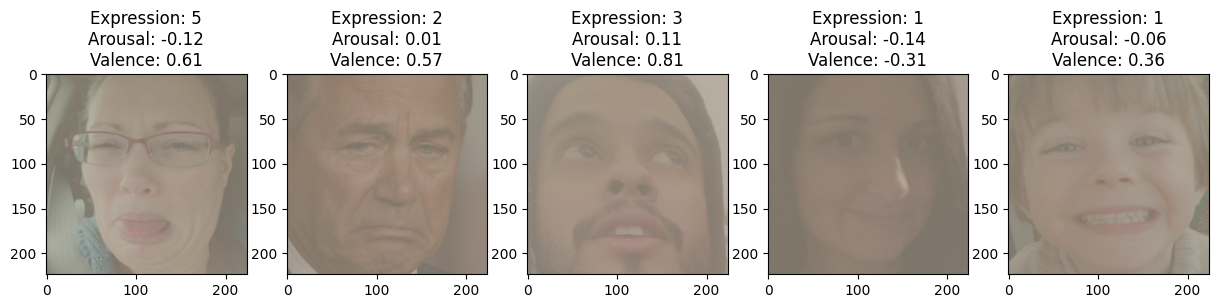

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 5 images and their labels
images, expression_labels, arousal_labels, valence_labels = next(iter(train_loader))
images = images[:5]
expression_labels = expression_labels[:5]

# Denormalize the images (undo the normalization done in the transform)
denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Convert expression labels from tensors to numpy arrays
expression_labels = expression_labels.numpy()

# Plot the images and their labels
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    # Transpose the image tensor to (height, width, channels) format for plotting
    img = denormalized_images[i].permute(1, 2, 0).numpy()
    ax[i].imshow(img)
    ax[i].set_title(f"Expression: {expression_labels[i]}\nArousal: {arousal[i]:.2f}\nValence: {valence[i]:.2f}")
    #labels = [f"{expressions_dict_rev[expression[i]]}\nArousal: {arousal[i]:.2f}\nValence: {valence[i]:.2f}" for i in range(64)]
plt.show()
#expressions_dict = {'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}

Installing the required model

In [5]:
pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Defining Custom Classifier and trainer classes 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet

class CustomClassifier(nn.Module):
    def __init__(self, in_features, num_classes_exp, num_classes_av):
        super(CustomClassifier, self).__init__()
        self.fc_exp = nn.Linear(in_features, num_classes_exp)
        self.fc_av = nn.Linear(in_features, num_classes_av)
        
    def forward(self, x):
        out_exp = self.fc_exp(x)
        out_av = self.fc_av(x)
        return out_exp, out_av

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes_exp=8, num_classes_av=2):
        super(EfficientNetModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        
        # Freeze layers
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        # Unfreeze last few layers
        layers_to_unfreeze = ['_blocks', '_conv_head']
        for name, child in self.efficientnet.named_children():
            if any(layer_name in name for layer_name in layers_to_unfreeze):
                for param in child.parameters():
                    param.requires_grad = True
        
        # Get the number of input features to the final fully connected layer
        num_ftrs = self.efficientnet._fc.in_features
        
        # Replace the final fully connected layer with a new one with the desired number of classes
        self.efficientnet._fc = CustomClassifier(num_ftrs, num_classes_exp, num_classes_av)
    
    def forward(self, x):
        out = self.efficientnet(x)
        return out
class Trainer():
    def __init__(self, model, class_criterion, reg_criterion, optimizer, device):
        self.model = model
        self.class_criterion = class_criterion
        self.reg_criterion = reg_criterion
        self.optimizer = optimizer
        self.device = device

    
    def accuracy_av(self, output_av, target_arousal, target_valence):
      pred_arousal, pred_valence = output_av[:, 0], output_av[:, 1]
      diff_arousal = pred_arousal - target_arousal
      diff_valence = pred_valence - target_valence
      rmse_arousal = torch.sqrt(torch.mean(diff_arousal**2))
      rmse_valence = torch.sqrt(torch.mean(diff_valence**2))
      return rmse_arousal, rmse_valence
    
    def train(self, train_loader):
        self.model.train()
        train_loss = 0
        correct_exp = 0
        rmse_arousal = 0
        rmse_valence = 0
            
        for batch_idx, (data, target_exp, target_arousal, target_valence) in enumerate(tqdm(train_loader)):
            data, target_exp, target_arousal, target_valence = data.to(self.device), target_exp.to(self.device), target_arousal.to(self.device), target_valence.to(self.device)
            self.optimizer.zero_grad()
            output_exp, output_av = self.model(data)
            loss_exp = self.class_criterion(output_exp, target_exp)
            loss_av = self.reg_criterion(output_av, torch.stack((target_arousal, target_valence), dim=1))
            loss = loss_exp + loss_av
            train_loss += loss.item()
            pred_exp = output_exp.argmax(dim=1, keepdim=True)
            correct_exp += pred_exp.eq(target_exp.view_as(pred_exp)).sum().item()
            rmse_ar, rmse_val = self.accuracy_av(output_av, target_arousal, target_valence)
            rmse_arousal += rmse_ar.item()
            rmse_valence += rmse_val.item()
                
            loss.backward()
            self.optimizer.step()
            
        train_loss /= len(train_loader.dataset)
        accuracy_exp = 100. * correct_exp / len(train_loader.dataset)
        rmse_arousal /= len(train_loader.dataset)
        rmse_valence /= len(train_loader.dataset)
        return train_loss, accuracy_exp, rmse_arousal, rmse_valence

    def validate(self, val_loader):
      self.model.eval()
      val_loss = 0
      correct_exp = 0
      rmse_arousal = 0
      rmse_valence = 0
      
      with torch.no_grad():
          for data, target_exp, target_arousal, target_valence in tqdm(val_loader):
              data, target_exp, target_arousal, target_valence = data.to(self.device), target_exp.to(self.device), target_arousal.to(self.device), target_valence.to(self.device)
              output_exp, output_av = self.model(data)
              loss_exp = self.class_criterion(output_exp, target_exp)
              loss_av = self.reg_criterion(output_av, torch.stack((target_arousal, target_valence), dim=1))
              loss = loss_exp + loss_av
              val_loss += loss.item()
              pred_exp = output_exp.argmax(dim=1, keepdim=True)
              correct_exp += pred_exp.eq(target_exp.view_as(pred_exp)).sum().item()
              rmse_ar, rmse_val = self.accuracy_av(output_av, target_arousal, target_valence)
              rmse_arousal += rmse_ar
              rmse_valence += rmse_val
      val_loss /= len(val_loader.dataset)
      accuracy_exp = 100. * correct_exp / len(val_loader.dataset)
      rmse_arousal /= len(val_loader.dataset)
      rmse_valence /= len(val_loader.dataset)
      return val_loss, accuracy_exp, rmse_arousal, rmse_valence



Define parameters to be used by the model

In [9]:
# Select a loss function
class_loss = torch.nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

model= EfficientNetModel().to(device);

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 20




Loaded pretrained weights for efficientnet-b0


In [10]:

# Initializing variables for starting a new training
# Some helper variables

num_epochs = 10
learning_rate = 0.001
momentum = 0.9
weight_decay = 1e-4
batch_size = 64
num_classes = 8




# Define loss function and optimizer
class_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)


train_accuracy_exp_list = []
train_rms_ar_list = []
train_rms_val_list = []
val_accuracy_exp_list = []
val_rms_ar_list = []
val_rms_val_list = []


train_loss_list = []
val_loss_list = []


val_accuracy_max_exp = -1
val_rms_min_ar = 2
val_rms_min_val = 2



checkpoint_path = '/content/drive/MyDrive/CV A2/effecientnet/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/drive/MyDrive/CV A2/effecientnet/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

Run this step to start training from scratch after above cell

In [21]:
import warnings
warnings.filterwarnings("ignore")

# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  trainer = Trainer(model=model, class_criterion=class_criterion,reg_criterion=reg_criterion, optimizer=optimizer, device=device)

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, accuracy_exp, rmse_arousal, rmse_valence  = trainer.train(train_loader)

  # Update the learning rate scheduler
  scheduler.step()

  train_accuracy_exp_list.append(accuracy_exp)
  train_rms_ar_list.append(rmse_arousal)
  train_rms_val_list.append(rmse_valence)
  train_loss_list.append(train_loss)
  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy_exp, val_rmse_arousal, val_rmse_valence  = trainer.validate(val_loader)
  
  # Lists for val loss and accuracy for plotting
  val_accuracy_exp_list.append(val_accuracy_exp)
  val_rms_ar_list.append(val_rmse_arousal)
  val_rms_val_list.append(val_rmse_valence)
  val_loss_list.append(val_loss)



  print('train loss: %.4f'%(train_loss))
  print('train_accuracy exp %.2f' % (accuracy_exp))
  print('train_rms arosal %.2f' % (rmse_arousal))
  print('train_rms Valance %.2f' % (rmse_valence))
  print('val loss: %.4f'%(val_loss))
  print('Val_accuracy exp %.2f' % (val_accuracy_exp))
  print('Val_rms arosal %.2f' % (val_rmse_arousal))
  print('Val_rms Valance %.2f' % (val_rmse_valence))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy_exp >= val_accuracy_max_exp and val_rms_min_ar >= val_rmse_arousal and val_rms_min_val >= val_rmse_valence :
    val_accuracy_max_exp = val_accuracy_exp
    val_rms_min_ar = val_rmse_arousal
    val_rms_min_val = val_rmse_valence
    print('New Max Expression accuracy and Min Valence & Arousal RMSE for Validation acheived. Saving model.\n\n')

    checkpoint = {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_accuracy_exp': train_accuracy_exp_list,
      'train_rms_val': train_rms_val_list,
      'train_rms_ar': train_rms_ar_list,
      'val_losses': val_loss_list,
      'val_expression_accuracies': val_accuracy_exp_list,
      'val_rms_val': val_rms_val_list,
      'val_rms_ar': val_rms_ar_list,
      'val_accuracy_max_exp': val_accuracy_max_exp,
      'val_rmse_val_min': val_rms_min_val,
      'val_rmse_aro_min': val_rms_min_ar,
      'lr': optimizer.param_groups[0]['lr']
      }
    torch.save(checkpoint, best_val_checkpoint_path)
  else:
      print("val accuracy and RMSEs did not improve.\n\n")
      checkpoint = {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_accuracy_exp': train_accuracy_exp_list,
      'train_rms_val': train_rms_val_list,
      'train_rms_ar': train_rms_ar_list,
      'val_losses': val_loss_list,
      'val_expression_accuracies': val_accuracy_exp_list,
      'val_rms_val': val_rms_val_list,
      'val_rms_ar': val_rms_ar_list,
      'val_accuracy_max_exp': val_accuracy_max_exp,
      'val_rmse_val_min': val_rms_min_val,
      'val_rmse_aro_min': val_rms_min_ar,
      'lr': optimizer.param_groups[0]['lr']
      }
      torch.save(checkpoint, checkpoint_path)
 


Epoch 10: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [27:09<00:00,  2.21it/s]


Epoch 10: Validation


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


train loss: 0.0099
train_accuracy exp 79.67
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0271
Val_accuracy exp 49.56
Val_rms arosal 0.01
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 11: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [25:55<00:00,  2.31it/s]


Epoch 11: Validation


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


train loss: 0.0097
train_accuracy exp 80.10
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0270
Val_accuracy exp 50.51
Val_rms arosal 0.01
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 12: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [25:57<00:00,  2.31it/s]


Epoch 12: Validation


100%|██████████| 63/63 [00:22<00:00,  2.75it/s]


train loss: 0.0094
train_accuracy exp 80.63
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0290
Val_accuracy exp 49.04
Val_rms arosal 0.01
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 13: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [26:12<00:00,  2.29it/s]


Epoch 13: Validation


100%|██████████| 63/63 [00:22<00:00,  2.76it/s]


train loss: 0.0092
train_accuracy exp 81.14
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0285
Val_accuracy exp 49.41
Val_rms arosal 0.01
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 14: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [26:15<00:00,  2.28it/s]


Epoch 14: Validation


100%|██████████| 63/63 [00:23<00:00,  2.68it/s]


train loss: 0.0089
train_accuracy exp 81.74
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0284
Val_accuracy exp 50.24
Val_rms arosal 0.01
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 15: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [26:23<00:00,  2.27it/s]


Epoch 15: Validation


100%|██████████| 63/63 [00:23<00:00,  2.72it/s]


train loss: 0.0087
train_accuracy exp 82.35
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0294
Val_accuracy exp 49.96
Val_rms arosal 0.01
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 16: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [26:07<00:00,  2.29it/s]


Epoch 16: Validation


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


train loss: 0.0084
train_accuracy exp 82.76
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0282
Val_accuracy exp 51.54
Val_rms arosal 0.01
Val_rms Valance 0.01
New Max Expression accuracy and Min Valence & Arousal RMSE for Validation acheived. Saving model.


Epoch 17: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [26:07<00:00,  2.29it/s]


Epoch 17: Validation


100%|██████████| 63/63 [00:23<00:00,  2.72it/s]


train loss: 0.0081
train_accuracy exp 83.39
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0309
Val_accuracy exp 50.64
Val_rms arosal 0.01
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 18: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [26:08<00:00,  2.29it/s]


Epoch 18: Validation


100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


train loss: 0.0078
train_accuracy exp 84.00
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0301
Val_accuracy exp 51.76
Val_rms arosal 0.01
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 19: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [26:01<00:00,  2.30it/s]


Epoch 19: Validation


100%|██████████| 63/63 [00:20<00:00,  3.01it/s]


train loss: 0.0076
train_accuracy exp 84.56
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0309
Val_accuracy exp 50.99
Val_rms arosal 0.01
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.




Run this cell first to update model parameters by using the saved checkpoint to resume training from that specific check point and then run the above cell

In [10]:
# Loading all variables from a checkpoint to continue a training

# Path to checkpoint
#last model
saved_checkpoint_path = '/content/drive/MyDrive/CV A2/effecientnet/checkpoint_norm_aug_tensorboard.pth'
#best model
#saved_checkpoint_path = '/content/drive/MyDrive/CV A2/best_val_checkpoint_norm_aug_tensorboard.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path,map_location=torch.device('cpu'))
print(checkpoint.keys())

# Load all the state_dictionaries of the model, optimizer and schedular
model.load_state_dict(checkpoint['model'])

optimizer.load_state_dict(checkpoint['optimizer'])

scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and loss lists for record keeping
train_accuracy_exp_list = checkpoint['train_accuracy_exp']
train_rms_val_list = checkpoint['train_rms_val']
train_rms_ar_list = checkpoint['train_rms_ar']

val_accuracy_exp_list = checkpoint['val_expression_accuracies']
val_rms_val_list = checkpoint['val_rms_val']
val_rms_ar_list = checkpoint['val_rms_ar']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy 
# over the previously saved model with better val accuracy
val_accuracy_max_exp = checkpoint['val_accuracy_max_exp']
val_rms_min_val = checkpoint['val_rmse_val_min']
val_rms_min_ar = checkpoint['val_rmse_aro_min']



dict_keys(['model', 'optimizer', 'scheduler', 'trianed_epochs', 'train_losses', 'train_accuracy_exp', 'train_rms_val', 'train_rms_ar', 'val_losses', 'val_expression_accuracies', 'val_rms_val', 'val_rms_ar', 'val_accuracy_max_exp', 'val_rmse_val_min', 'val_rmse_aro_min', 'lr'])


In [11]:
checkpoint['val_expression_accuracies']


[44.51112778194549,
 45.23630907726932,
 46.186546636659166,
 46.78669667416854,
 47.83695923980995,
 48.41210302575644,
 48.637159289822456,
 48.312078019504874,
 49.03725931482871,
 48.76219054763691,
 49.56239059764941,
 50.51262815703926,
 49.03725931482871,
 49.41235308827207,
 50.23755938984746,
 49.962490622655665,
 51.53788447111778,
 50.637659414853715,
 51.7629407351838,
 50.98774693673418]

In [12]:
checkpoint['trianed_epochs']

19

In [20]:
start_epoch

10

Visualizing Training performance

Text(0.5, 1.0, 'Training and val Loss')

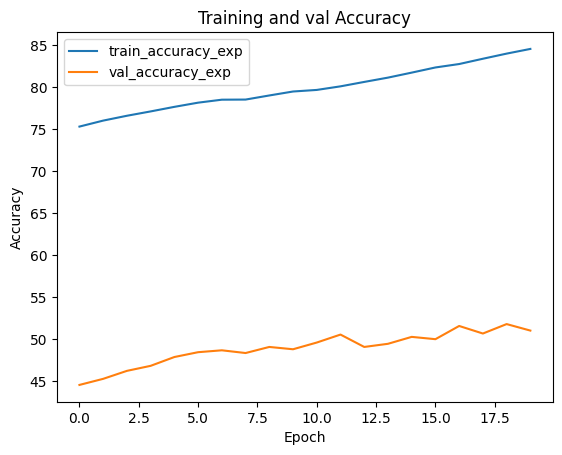

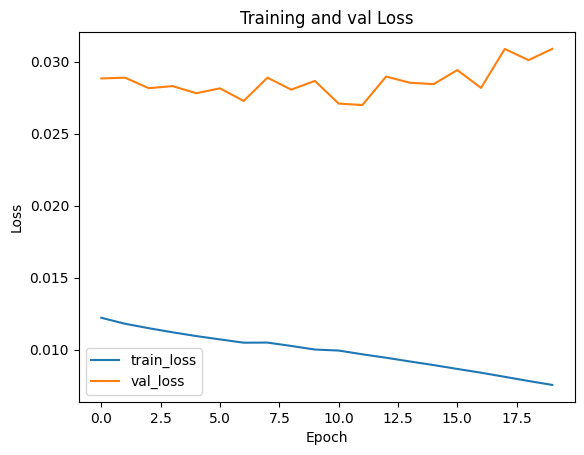

In [25]:
plt.figure()
plt.plot(train_accuracy_exp_list, label="train_accuracy_exp")
plt.plot(val_accuracy_exp_list, label="val_accuracy_exp")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

Functions to compute parameters after testing

In [13]:
from sklearn.metrics import auc

def auc_fn(predictions, labels):
  # convert preds and labs to numpy arrays
  preds = np.array(predictions)
  labs = np.array(labels)

  # calculate the one-hot encoding of the labels
  n_classes = len(np.unique(labs))
  one_hot_labs = np.zeros((len(labs), n_classes))
  one_hot_labs[np.arange(len(labs)), labs] = 1

  # calculate the ROC curve and AUC for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(one_hot_labs[:, i], preds == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

  # calculate the average AUC across all classes
  avg_auc = np.mean(list(roc_auc.values()))
  return avg_auc
  


In [11]:

import numpy as np

def nominal_distance(x, y):
    return x != y

def krippendorff_alpha(y_true, y_pred):
    # Calculate the pairwise distance matrix
    n = len(y_true)
    dist_mat = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            dist_mat[i,j] = nominal_distance(y_true[i], y_true[j])
            dist_mat[j,i] = dist_mat[i,j]
    
    # Calculate the observed agreement
    obs_agr = np.mean(np.array(y_true) == np.array(y_pred))
    
    # Calculate the expected agreement
    exp_agr = 0
    for i in range(n):
        for j in range(i+1, n):
            exp_agr += dist_mat[i,j] == nominal_distance(y_pred[i], y_pred[j])
    exp_agr /= (n*(n-1)/2)
    
    # Calculate alpha
    alpha_krippendorff = 1 - (obs_agr / exp_agr)
    return alpha_krippendorff




Testing loop

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import pearsonr, linregress
import numpy as np

# Load the best validation checkpoint
best_val_model_path = '/content/drive/MyDrive/CV A2/effecientnet/best_val_checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
model.load_state_dict(best_val_checkpoint['model'])


y_true = []
y_pred = []
arousal_pred =[]
valence_pred =[]
arousal_true =[]
valence_true =[]
with torch.no_grad():
  for images, expression, arousal, valence in tqdm(test_loader):
      output_exp, output_av = model(images.to(device))
      y_true.extend(expression.detach().cpu().numpy())
      y_pred.extend(torch.argmax(output_exp, axis=1).detach().cpu().numpy())
      arousal_pred.extend(output_av[:, 0].detach().cpu().numpy())
      valence_pred.extend(output_av[:, 1].detach().cpu().numpy())
      arousal_true.extend(arousal.detach().cpu().numpy())
      valence_true.extend(valence.detach().cpu().numpy())




100%|██████████| 57531/57531 [1:57:32<00:00,  8.16it/s]


Computing and Visualizing Performance Measures

In [18]:
!pip install krippendorff


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
# Compute accuracy and F1 score
acc = accuracy_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred, average='weighted')
auc_pr = auc_fn(y_pred,y_true)


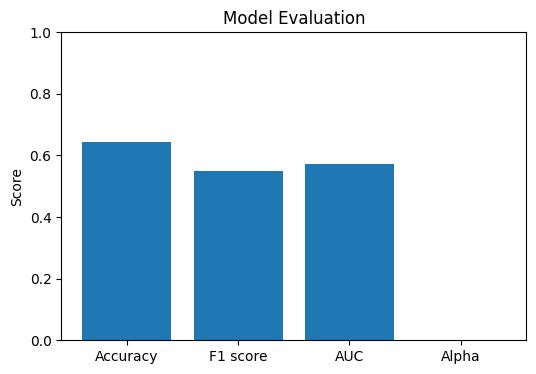

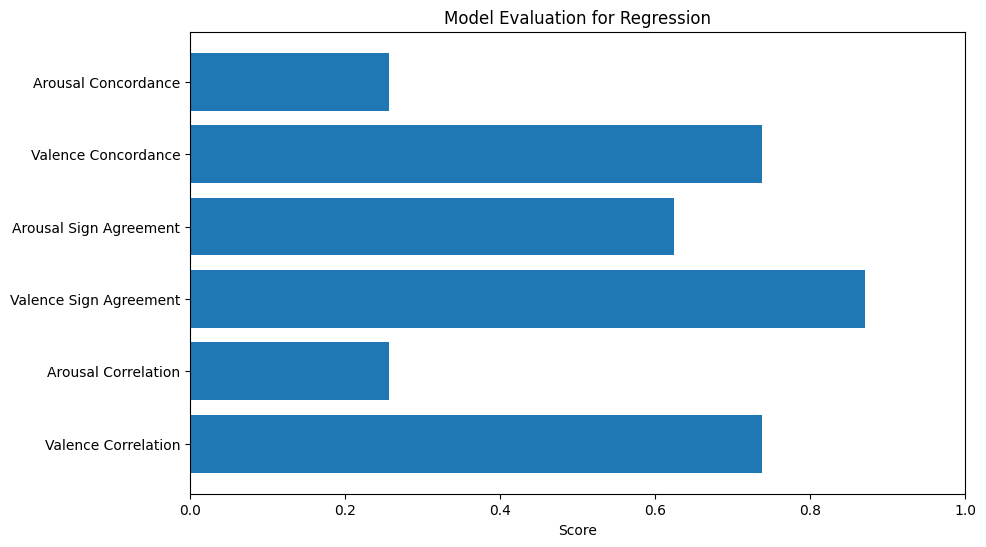

In [21]:
# Compute Pearson correlation coefficient for valence and arousal
valence_corr, _ = pearsonr(valence_true, valence_pred)
arousal_corr, _ = pearsonr(arousal_true, arousal_pred)

# Compute sign agreement metric for valence and arousal
valence_sign_agreement = np.mean(np.sign(valence_true- np.median(valence_true)) == np.sign(valence_pred - np.median(valence_pred)))
arousal_sign_agreement = np.mean(np.sign(arousal_true - np.median(arousal_true)) == np.sign(arousal_pred - np.median(arousal_pred)))

# Compute concordance correlation coefficient for valence and arousal
valence_concordance = linregress(valence_true, valence_pred).rvalue
arousal_concordance = linregress(arousal_true, arousal_pred).rvalue


# Plot accuracy and F1 score
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Accuracy', 'F1 score','AUC','Alpha'], [acc, f1score,auc_pr,alpha_krippendorff])
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Model Evaluation')
plt.show()


# Plot performance measures
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(['Valence Correlation', 'Arousal Correlation', 'Valence Sign Agreement', 'Arousal Sign Agreement', 'Valence Concordance', 'Arousal Concordance'],
       [valence_corr, arousal_corr, valence_sign_agreement, arousal_sign_agreement, valence_concordance, arousal_concordance])
ax.set_xlim([0, 1])
ax.set_xlabel('Score')
ax.set_title('Model Evaluation for Regression')
plt.show()